# Inference

## Upload your erd diagram here.

Saving schema_0000.png to schema_0000 (6).png
--- Input Image ---


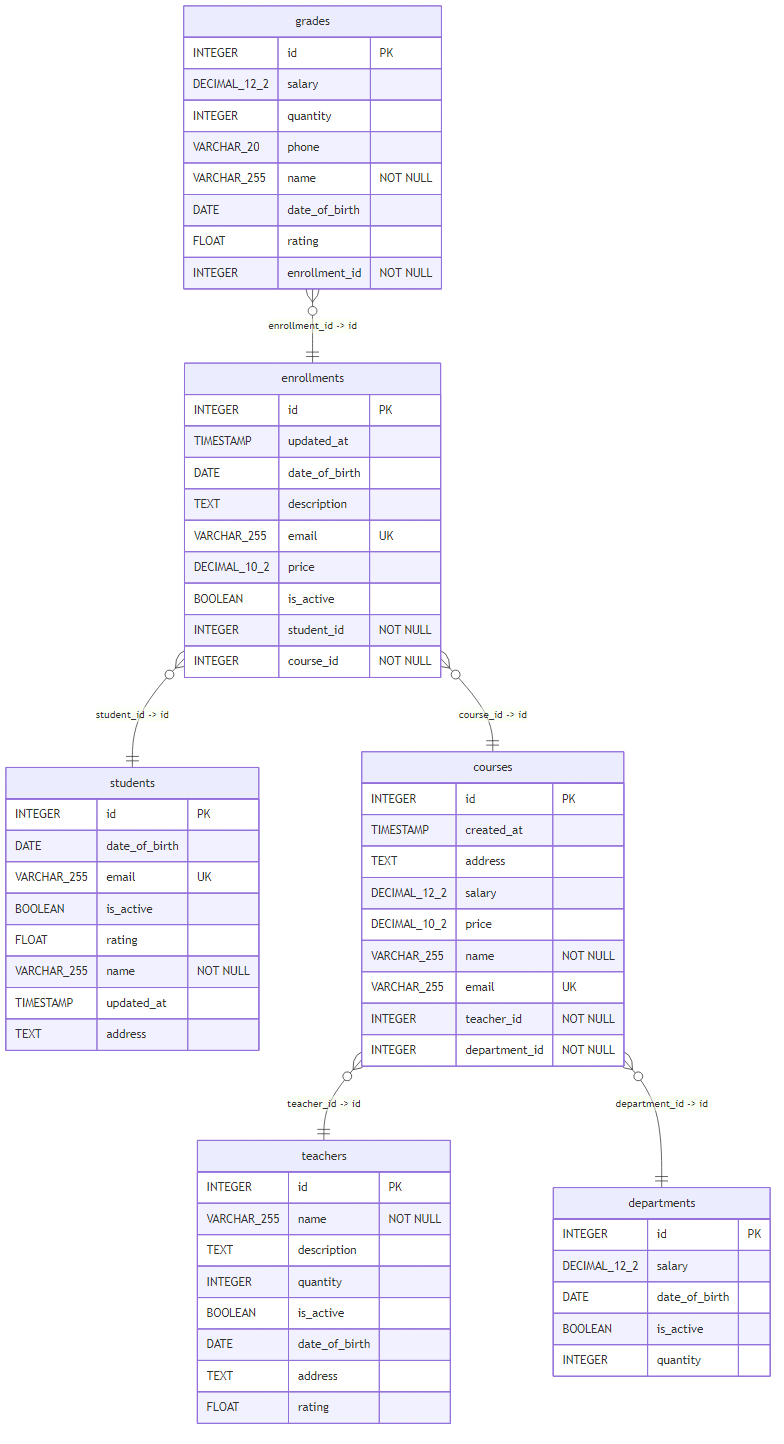

In [24]:
from PIL import Image
import json
from IPython.display import display
from google.colab import files
import io
# Upload the image
uploaded = files.upload()

# Get the first uploaded file
image_name = next(iter(uploaded))
image_bytes = uploaded[image_name]

# Open the image using PIL
image = Image.open(io.BytesIO(image_bytes)).convert("RGB")

# --- Display the image ---
print("--- Input Image ---")
display(image)

## This will be our system prompts and prompt to infer

In [12]:
prompt = "Extract data in JSON format"
SYSTEM_MESSAGE = """You are a Vision Language Model specialized in extracting structured database schema information from ER diagrams.

Your task is to analyze the provided database schema diagram and extract the complete schema information into a well-structured JSON format.

The diagram shows tables with their columns, data types, primary keys, foreign keys, and relationships between tables.

Focus on identifying:
1. All table names accurately
2. All column names and their data types
3. Primary keys
4. Foreign key relationships between tables
5. Data constraints (NOT NULL, UNIQUE, DEFAULT values)

Provide only the JSON output based on the extracted information. Avoid additional explanations or comments."""

messages = [
    {
        "role": "system",
        "content": [{"type": "text", "text": SYSTEM_MESSAGE}],
    },
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {"type": "text", "text": prompt}
        ]
    }
]

## Finetuned version

### Let's load the finetuned model first

In [13]:
from transformers import AutoProcessor, Qwen2_5_VLForConditionalGeneration
import torch
from PIL import Image
import json
from IPython.display import display
from google.colab import files
import io

# Load the model and processor from the Hugging Face Hub
model_id = "zodiac2525/Qwen2.5-VL-Diagrams2SQL-v2"
processor = AutoProcessor.from_pretrained(model_id)
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(model_id, torch_dtype=torch.bfloat16, device_map="auto")



Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### Here we run our finetuned model

In [14]:
# Process the inputs
text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
inputs = processor(text=[text], images=[image], return_tensors="pt").to("cuda")

# Generate the output
generated_ids = model.generate(
    inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    attention_mask=inputs["attention_mask"],
    image_grid_thw=inputs["image_grid_thw"],
    max_new_tokens=4096,
    do_sample=False
)

# Decode the output
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

# Print the generated JSON
print("\n--- Generated Output ---")
# Find the start of the JSON object
json_start_index = generated_text.find('{')
if json_start_index != -1:
    json_output = generated_text[json_start_index:]
    # Pretty-print the JSON
    parsed_json = json.loads(json_output)
    print(json.dumps(parsed_json, indent=2))
else:
    print("Could not find JSON in the output.")
    print(generated_text)

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



--- Generated Output ---
{
  "domain": "school",
  "source": "programmatic",
  "tables": [
    {
      "name": "students",
      "columns": [
        {
          "name": "id",
          "type": "INTEGER",
          "primary_key": true
        },
        {
          "name": "date_of_birth",
          "type": "DATE"
        },
        {
          "name": "email",
          "type": "VARCHAR(255)",
          "unique": true
        },
        {
          "name": "is_active",
          "type": "BOOLEAN",
          "default": "true"
        },
        {
          "name": "rating",
          "type": "FLOAT"
        },
        {
          "name": "name",
          "type": "VARCHAR(255)",
          "nullable": false
        },
        {
          "name": "updated_at",
          "type": "TIMESTAMP",
          "default": "CURRENT_TIMESTAMP"
        },
        {
          "name": "address",
          "type": "TEXT"
        }
      ]
    },
    {
      "name": "teachers",
      "columns": [
       

## Base Model (Unfinetuned)

### Load the Base Model

In [15]:
# Load the base model and processor
base_model_id = "Qwen/Qwen2.5-VL-3B-Instruct"
processor = AutoProcessor.from_pretrained(base_model_id)
base_model = Qwen2_5_VLForConditionalGeneration.from_pretrained(base_model_id, torch_dtype=torch.bfloat16, device_map="auto")


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [25]:
# Process the inputs
text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
inputs = processor(text=[text], images=[image], return_tensors="pt").to("cuda")
# Generate the output
generated_ids = base_model.generate(
    inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    attention_mask=inputs["attention_mask"],
    image_grid_thw=inputs["image_grid_thw"],
    max_new_tokens=4096,
    do_sample=False
)

# Decode the output
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

# Print the generated JSON
print("\n--- Generated Output (Base Model) ---")
# Find the start of the JSON object
json_start_index = generated_text.find('{')
if json_start_index != -1:
    json_output = generated_text[json_start_index:]
    # Try to parse the JSON, and if it fails, add a closing bracket and try again
    try:
        parsed_json = json.loads(json_output)
        print(json.dumps(parsed_json, indent=2))
    except json.JSONDecodeError:
        try:
            # Add a closing bracket and try to parse again
            json_output += '}'
            parsed_json = json.loads(json_output)
            print(json.dumps(parsed_json, indent=2))
        except json.JSONDecodeError:
            print(json_output)
else:
    print("Could not find JSON in the output.")
    print(generated_text)

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



--- Generated Output (Base Model) ---
{
  "tables": [
    {
      "name": "grades",
      "columns": [
        { "name": "id", "type": "INTEGER", "is_pk": true },
        { "name": "salary", "type": "DECIMAL_12_2" },
        { "name": "quantity", "type": "INTEGER" },
        { "name": "phone", "type": "VARCHAR_20" },
        { "name": "name", "type": "VARCHAR_255", "is_not_null": true },
        { "name": "date_of_birth", "type": "DATE" },
        { "name": "rating", "type": "FLOAT" },
        { "name": "enrollment_id", "type": "INTEGER", "is_not_null": true }
      ],
      "primary_key": "id"
    },
    {
      "name": "enrollments",
      "columns": [
        { "name": "id", "type": "INTEGER", "is_pk": true },
        { "name": "updated_at", "type": "TIMESTAMP" },
        { "name": "date_of_birth", "type": "DATE" },
        { "name": "description", "type": "TEXT" },
        { "name": "email", "type": "VARCHAR_255", "is_unique": true },
        { "name": "price", "type": "DECIMAL_10

# Evaluation

- The first output (Base Model) provides a relatively structured JSON schema of the database, detailing tables, columns, data types, and some constraints.
However, it suffers from several issues.

- For example, foreign key relationships are inaccurately defined, with several self-references that misrepresent actual relational links between tables. Also, Constraints like NOT_NULL and UNIQUE are inconsistently applied.

- In contrast, the second output is more logically consistent, cleanly structured, and directly usable. It embeds constraints such as primary_key, nullable, default, and unique within each column definition, making the schema easier to read and maintain. Foreign key relationships are explicitly and correctly defined under a relationships section using a normalized format, improving both accuracy and semantic transparency. Overall, the second schema is more complete, logically valid, and production-ready, making it the superior of the two.